In [1]:
import re
import emoji
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from tqdm import tqdm
from string import punctuation
from sklearn.metrics import f1_score, accuracy_score, classification_report

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
from flashtext import KeywordProcessor

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline

from string import punctuation
from nltk.stem.snowball import SnowballStemmer

from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [2]:
sns.set_theme()
tqdm.pandas()

In [3]:
DATA_PATH = 'data'
RANDOM_STATE = 42
COMPANY_REGEX = r'".+"'

In [4]:
df = pd.read_pickle('data/sentiment_texts.pickle')
df.head()

,MessageID,ChannelID,issuerid,SentimentScore,DateAdded,DatePosted,MessageText,IsForward
0,241407,1203560567,153,2,2023-05-12 19:03:20,2023-05-12 19:02:42,⚠️🇷🇺#SELG #дивиденд сд Селигдар: дивиденды 20...,False
1,33684,1136626166,230,4,2023-02-03 20:56:29,2023-02-03 16:46:34,Ozon продолжает развивать специализированные ф...,False
2,10090,1063908560,118,4,2023-06-02 19:18:37,2023-06-02 18:50:00,​Фокусы продолжаются🔥Акции и инвестиции 📈ВТБ ...,False
3,10090,1063908560,220,5,2023-06-02 19:18:37,2023-06-02 18:50:00,​Фокусы продолжаются🔥Акции и инвестиции 📈ВТБ ...,False
4,9826,1063908560,89,2,2023-04-24 17:51:38,2023-04-24 13:54:00,​​Windfall Tax — налог на сверхприбыль. Какие ...,False


Создаем префиксное дерево

In [5]:
synonyms_mapper = pd.read_excel(DATA_PATH + f'/names and synonyms.xlsx', index_col='issuerid')
synonyms_mapper['extended'] = synonyms_mapper['BGTicker'].apply(lambda x: x.split()[0] if not pd.isna(x) else x)

synonyms_mapper['extended_2'] = synonyms_mapper['EMITENT_FULL_NAME'].apply(
    lambda x: re.findall(COMPANY_REGEX, x)[0] if re.findall(COMPANY_REGEX, x) else None
)
synonyms_cols = ['EMITENT_FULL_NAME', 'VeryOddCompany', 'BGTicker', 'BGTicker.1',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'extended', 'extended_2']

synonyms_list = synonyms_mapper[synonyms_cols].values
synonyms_list = [[f'{synonym.strip()}' for synonym in synonyms_list if not pd.isna(synonym)] for synonyms_list in synonyms_list]

keyword_dict = dict(zip(synonyms_mapper.index.values, synonyms_list))
keyword_preprocessor = KeywordProcessor()
keyword_preprocessor.add_keywords_from_dict(keyword_dict)

In [6]:
df['mention'] = df['MessageText'].progress_apply(keyword_preprocessor.extract_keywords).apply(lambda x: list(set(x)))
df['mention_predict'] = df.apply(lambda x: x['issuerid'] if x['issuerid'] in x['mention'] else 4242, axis=1)

100%|██████████| 9289/9289 [00:09<00:00, 934.39it/s] 


In [7]:
f1_score(df['issuerid'], df['mention_predict'], average='macro')

0.9656313003164485

Подготовим датасет для обучения модели:

In [16]:
def prepare_dataset(x, keyword_preprocessor):
    text = x['MessageText']
    if len(x['mention']) == 0:
        return 
    if len(x['mention']) > 1:

        if emoji.emoji_count(text) > 0:
            texts = [s.strip() for s in re.split(r':[а-я_]+:', emoji.demojize(text, language='ru')) if s.strip()]
        else:
            texts = nltk.sent_tokenize(text)
        res = ' '.join([
            txt for txt in texts 
            for mnt in keyword_preprocessor.extract_keywords(txt)
            if mnt == x['issuerid'] 
        ])
        return res
    else: 
        return text

In [17]:
df['dataset'] = df.progress_apply(lambda x: prepare_dataset(x, keyword_preprocessor), axis=1)

100%|██████████| 9289/9289 [00:24<00:00, 379.40it/s]


In [18]:
df[['dataset', 'SentimentScore']]

,dataset,SentimentScore
0,⚠️🇷🇺#SELG #дивиденд сд Селигдар: дивиденды 20...,2
1,Ozon продолжает развивать специализированные ф...,4
2,НМТП +3.9% ДВМП +3.7% После разрывного отчёта ...,4
3,"GLTR +3.6% БКС МИ пишет, что ставки аренды пол...",5
4,,2
...,...,...
9284,#FLOT #Дивиденды 💰 7% — возможная дивдоходност...,4
9285,🇷🇺#FLOT #отчетность ЧИСТАЯ ПРИБЫЛЬ СОВКОМФЛОТ...,4
9286,"Есть еще Вечные портфели (напр. Тинькофф), в к...",3
9287,"""💥🇷🇺#PLZL #листинг #торги """"Полюс"""" ведет диа...",3


Пробуем dostoevsky + классификатор для отображения результатов:

In [19]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

In [20]:
stop_words = []
# stop_words = [company.lower() for lst in keyword_dict.values() for company in lst]
stop_words += list(punctuation)
stop_words.remove('+')
stop_words.remove('-')

In [21]:
dataset = df[['dataset', 'SentimentScore']]
dataset = dataset[dataset['SentimentScore'] != 0]
dataset = dataset.dropna()
dataset = dataset[dataset['dataset'] != '']
dataset.shape

(8854, 2)

In [22]:
results = model.predict(dataset['dataset'], k=5)

In [23]:
results_df = pd.DataFrame(results, index=dataset.index)
results_df['target'] = dataset['SentimentScore']
results_df.head()

,neutral,skip,positive,negative,speech,target
0,0.615098,0.287778,0.028446,0.026769,0.003183,2
1,0.890304,0.071601,0.050341,0.129413,0.005070,4
2,0.924152,0.065615,0.026769,0.160276,0.002900,4
3,0.622469,0.132974,0.144159,0.119213,0.012064,5
5,0.743178,0.129413,0.023699,0.187143,0.014967,2


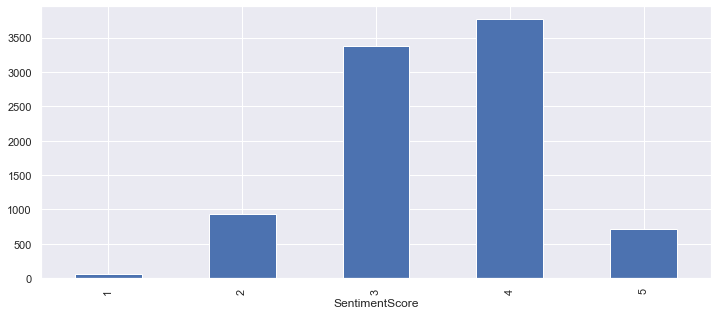

In [24]:
dataset.groupby(['SentimentScore']).count()['dataset'].plot(kind='bar', figsize=(12, 5));

Пробуем TF-IDF + Stemming + SVM:

In [25]:
stem = SnowballStemmer('russian')
dataset['stem'] = dataset['dataset'].progress_apply(stem.stem)

100%|██████████| 8854/8854 [00:01<00:00, 5121.95it/s]


In [27]:
pipe = Pipeline([
    ('text_preprocessing', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 4))),
    ('classifier', LinearSVC(random_state=RANDOM_STATE, class_weight={1: 0, 2: 1.8, 3: 1.5, 4: 1, 5: 1.5}))
])
# scores = cross_val_score(pipe, dataset['dataset'], dataset['SentimentScore'], cv=6, scoring='accuracy')
scores = cross_val_score(pipe, dataset['stem'], dataset['SentimentScore'], cv=8, scoring='accuracy')

print(f'mean: {np.mean(scores)}')
scores

mean: 0.6418622206867035


array([0.63775971, 0.62782294, 0.62511292, 0.6097561 , 0.6395664 ,
       0.6630533 , 0.6636528 , 0.6681736 ])

Пробуем TF-IDF + SVM:

In [28]:
folds = 8
kfold = KFold(folds)
accuracy_scores = []

for train_idx, test_idx in kfold.split(dataset['dataset'], dataset['SentimentScore']):
    pipe = Pipeline([
        ('text_preprocessing', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 4))),
        ('classifier', LinearSVC(random_state=RANDOM_STATE, class_weight={1: 0, 2: 1.8, 3: 1.5, 4: 1, 5: 1.5}))
    ])
    X_train, y_train = dataset.iloc[train_idx]['dataset'], dataset.iloc[train_idx]['SentimentScore']
    X_test, y_test = dataset.iloc[test_idx]['dataset'], dataset.iloc[test_idx]['SentimentScore']
    pipe.fit(X_train, y_train)
    accuracy_scores.append(pipe.score(X_test, y_test))
    print(classification_report(y_test, pipe.predict(X_test)))
    print('-' * 30)

np.mean(accuracy_scores)

c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        14
           2       0.66      0.23      0.34       120
           3       0.67      0.67      0.67       461
           4       0.58      0.73      0.65       414
           5       0.59      0.49      0.53        98

    accuracy                           0.62      1107
   macro avg       0.50      0.42      0.44      1107
weighted avg       0.62      0.62      0.60      1107

------------------------------


c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         4
           2       0.66      0.31      0.42       154
           3       0.65      0.61      0.63       418
           4       0.62      0.80      0.70       444
           5       0.67      0.60      0.63        87

    accuracy                           0.64      1107
   macro avg       0.52      0.46      0.48      1107
weighted avg       0.64      0.64      0.63      1107

------------------------------


c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         7
           2       0.40      0.21      0.27        81
           3       0.74      0.68      0.71       470
           4       0.64      0.76      0.69       447
           5       0.55      0.53      0.54       102

    accuracy                           0.66      1107
   macro avg       0.47      0.44      0.44      1107
weighted avg       0.65      0.66      0.65      1107

------------------------------


c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.43      0.27      0.33        97
           3       0.62      0.69      0.65       389
           4       0.66      0.70      0.68       497
           5       0.63      0.46      0.53       115

    accuracy                           0.63      1107
   macro avg       0.47      0.42      0.44      1107
weighted avg       0.62      0.63      0.62      1107

------------------------------


c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         8
           2       0.52      0.36      0.43       108
           3       0.70      0.63      0.66       411
           4       0.64      0.77      0.70       493
           5       0.55      0.48      0.51        87

    accuracy                           0.65      1107
   macro avg       0.48      0.45      0.46      1107
weighted avg       0.64      0.65      0.64      1107

------------------------------


c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.67      0.37      0.48       127
           3       0.68      0.66      0.67       404
           4       0.65      0.77      0.70       481
           5       0.61      0.53      0.57        86

    accuracy                           0.66      1107
   macro avg       0.52      0.47      0.48      1107
weighted avg       0.65      0.66      0.65      1107

------------------------------


c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.84      0.34      0.49       122
           3       0.72      0.66      0.69       426
           4       0.64      0.80      0.71       482
           5       0.67      0.59      0.63        71

    accuracy                           0.68      1106
   macro avg       0.57      0.48      0.50      1106
weighted avg       0.69      0.68      0.67      1106

------------------------------
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.60      0.35      0.45       116
           3       0.70      0.66      0.68       405
           4       0.69      0.79      0.73       509
           5       0.61      0.59      0.60        74

    accuracy                           0.68      1106
   macro avg       0.52      0.48      0.49      1106
weighted avg       0.68      0.68      0.67   

c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sveta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

0.6521412113608779

Сохраняем результаты

In [29]:
pipe = Pipeline([
    ('text_preprocessing', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 4))),
    ('classifier', LinearSVC(random_state=RANDOM_STATE, class_weight={1: 0, 2: 1.8, 3: 1.5, 4: 1, 5: 1.5}))
])
X_train, y_train = dataset['dataset'], dataset['SentimentScore']
pipe.fit(X_train, y_train)

Pipeline(steps=[('text_preprocessing',
                 TfidfVectorizer(ngram_range=(1, 4),
                                 stop_words=['!', '"', '#', '$', '%', '&', "'",
                                             '(', ')', '*', ',', '.', '/', ':',
                                             ';', '<', '=', '>', '?', '@', '[',
                                             '\\', ']', '^', '_', '`', '{', '|',
                                             '}', '~'])),
                ('classifier',
                 LinearSVC(class_weight={1: 0, 2: 1.8, 3: 1.5, 4: 1, 5: 1.5},
                           random_state=42))])

In [30]:
with open('sentiment.pkl', 'wb') as file:
    pickle.dump(pipe, file)

In [31]:
with open('ner_dict.pkl', 'wb') as file:
    pickle.dump(keyword_dict, file)